This notebook tests various neural processes on a toy 1d regression problem. The problem is from the [deep mind papers](https://github.com/deepmind/neural-processes).

Results:

|model|test_loss|
|-----|---------|
|ANP-RNN| -0.62|
| ANP-RNN(impr)| -1.3217|
| ANP| -0.4228|
| ANP(impr)| -0.3182|
| NP|   |

In [1]:
%matplotlib inline
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import collections
from tqdm.auto import tqdm
from tensorboardX import SummaryWriter

import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [4]:
from src.data.gp_curves import GPCurvesReader
from src.models.model import LatentModel

## Util

In [5]:
def set_seed(n=42):
    np.random.seed(n)
    torch.manual_seed(n)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

In [6]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, std):
    """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape [B,num_targets,1] that contains the
        x values of the target points.
    target_y: An array of shape [B,num_targets,1] that contains the
        y values of the target points.
    context_x: An array of shape [B,num_contexts,1] that contains 
        the x values of the context points.
    context_y: An array of shape [B,num_contexts,1] that contains 
        the y values of the context points.
    pred_y: An array of shape [B,num_targets,1] that contains the
        predicted means of the y values at the target points in target_x.
    std: An array of shape [B,num_targets,1] that contains the
        predicted std dev of the y values at the target points in target_x.
      """
    # Plot everything
    plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
    plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
    plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
    plt.fill_between(
          target_x[0, :, 0],
          pred_y[0, :, 0] - std[0, :, 0],
          pred_y[0, :, 0] + std[0, :, 0],
          alpha=0.25,
          facecolor='blue',
          interpolate=True)

    # Make the plot pretty
    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2, 0, 2], fontsize=16)
    plt.ylim([-2, 2])
    plt.grid('off')
    ax = plt.gca()

In [7]:
def test(model, dataset_test, writer=None, plot=False, global_step=None, seed=42, title=''):
    model.eval()
    with torch.no_grad():
        data_test = dataset_test.generate_curves()

        (context_x, context_y), target_x = data_test.query
        target_y = data_test.target_y

        context_x = context_x.cuda()
        context_y = context_y.cuda()
        target_x = target_x.cuda()
        target_y = target_y.cuda()

        y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x, target_y)

        # Lets order the result, for plotting
        target_inds = torch.argsort(target_x[0, :, 0])
        target_x = target_x[:, target_inds, :]
        target_y = target_y[:, target_inds, :]
        context_inds = torch.argsort(context_x[0, :, 0])
        context_y = context_y[:, context_inds, :]
        context_x = context_x[:, context_inds, :]
        y_pred = y_pred[:, target_inds, :]
        y_std = y_std[:, target_inds, :]
        
        if writer is not None:
            writer.add_scalar('val/loss', loss, global_step=global_step)
            writer.add_scalar('val/y_std', y_std.mean(), global_step=global_step)
            writer.add_scalar('val/mse_loss', mse_loss, global_step=global_step)
            writer.add_scalar('val/kl', kl.mean(), global_step=global_step)
        
        if plot:
            set_seed(seed)
            fig = plt.figure()
            plt.title(f"{title}. Iter {global_step}")            
            plot_functions(target_x.detach().cpu().numpy(),
                           target_y.detach().cpu().numpy(),
                           context_x.detach().cpu().numpy(),
                           context_y.detach().cpu().numpy(),
                           y_pred.detach().cpu().numpy(),
                           y_std.detach().cpu().numpy())
            
            writer.add_figure('test', fig, global_step=global_step, close=False)
            plt.show()
            
    return y_pred, kl, loss, y_std

In [8]:
def evaluate(model, dataset_test, n=100):
    return torch.stack([
        test(model, dataset_test)[2] for _ in tqdm(range(n))
    ]).mean().cpu()

# Init

In [9]:
MAX_CONTEXT_POINTS = 50
random_kernel_parameters = True

dataset_train = GPCurvesReader(
    batch_size=16,
    max_num_context=MAX_CONTEXT_POINTS,
    random_kernel_parameters=random_kernel_parameters,
    sequential=True,
)

dataset_test = GPCurvesReader(
    batch_size=1,
    max_num_context=MAX_CONTEXT_POINTS,
    testing=True,
    random_kernel_parameters=random_kernel_parameters,
    sequential=True,
)

## Replicate ANP paper

In [10]:
epochs = 100000
PLOT_AFTER = sorted(set([100, 200, 400, 1000, 2000, 4000, 8000] + list(range(0, epochs+1, 10000))))
PRINT_AFTER = 1000

runs/Feb15_15-25-36_mjcdesktop-anp-rnn_1d_reg



train: 0 loss= 1.194 val_loss= 0.9067


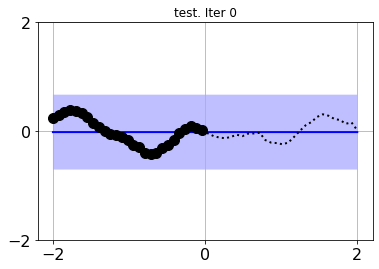

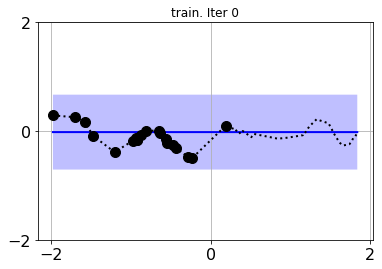

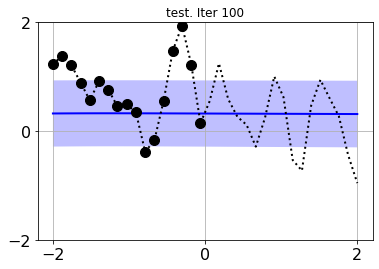

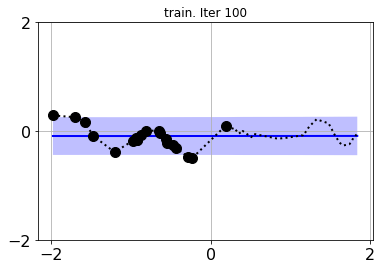

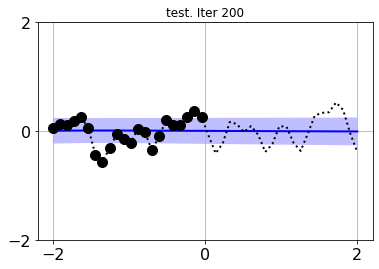

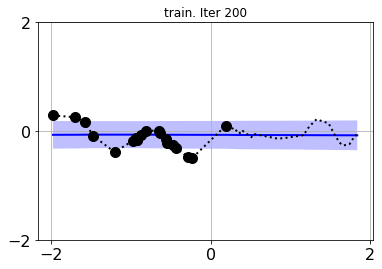

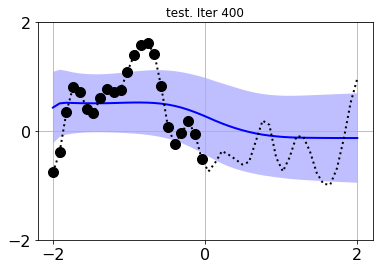

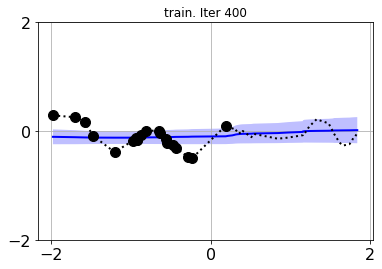


train: 1000 loss= 0.06843 val_loss= 0.3942


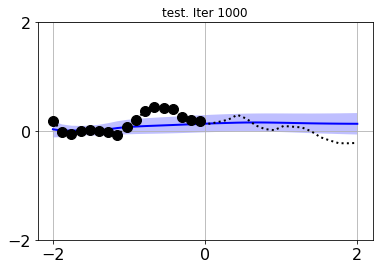

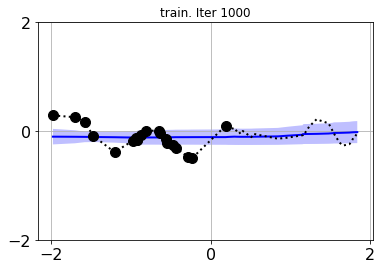


train: 2000 loss=-0.23 val_loss=-0.04989


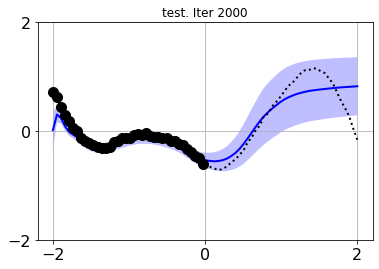

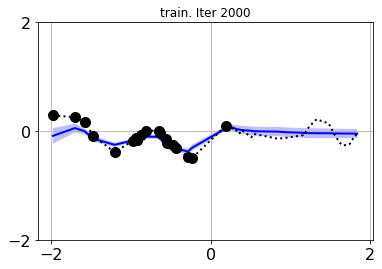


train: 3000 loss=-0.8103 val_loss=-0.1836



train: 4000 loss=-0.8786 val_loss=-0.2029


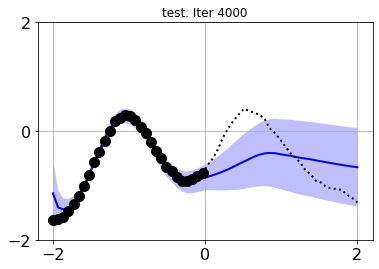

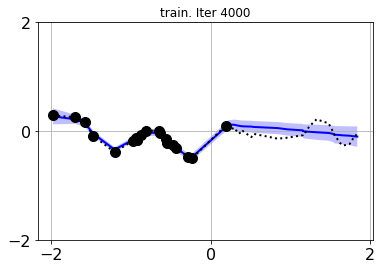


train: 5000 loss=-0.8079 val_loss= 0.0879



train: 6000 loss=-0.5261 val_loss=-0.1047



train: 7000 loss=-1.203 val_loss=-0.3966



train: 8000 loss=-1.306 val_loss=-0.5159


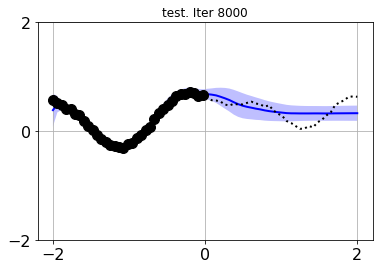

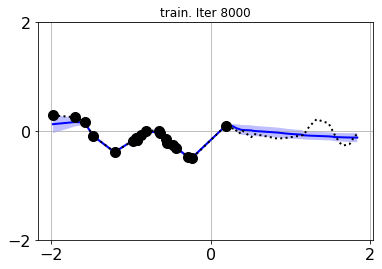


train: 9000 loss=-0.003201 val_loss= 0.3222



train: 10000 loss= 0.1244 val_loss= 0.3631


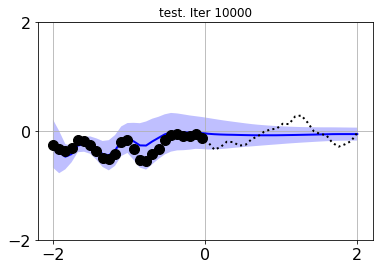

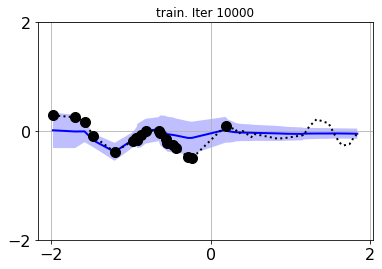


train: 11000 loss=-1.856 val_loss=-0.5413



train: 12000 loss=-0.4814 val_loss=-0.6354



train: 13000 loss=-0.4139 val_loss=-0.5292



train: 14000 loss=-1.457 val_loss=-0.5155



train: 15000 loss=-1.4 val_loss=-0.2926



train: 16000 loss=-1.184 val_loss=-0.3271



train: 17000 loss= 0.2559 val_loss= 0.325



train: 18000 loss=-0.1159 val_loss=-0.619



train: 19000 loss=-1.764 val_loss=-0.7266



train: 20000 loss= 0.1455 val_loss= 0.1659


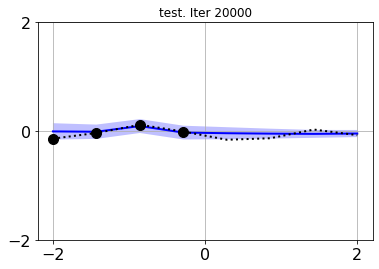

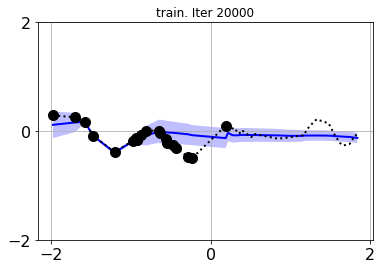


train: 21000 loss=-0.6126 val_loss=-0.09824



train: 22000 loss=-1.925 val_loss=-0.6129



train: 23000 loss=-1.154 val_loss=-0.1765



train: 24000 loss= 0.4868 val_loss= 0.6587



train: 25000 loss=-1.98 val_loss=-0.7969



train: 26000 loss=-1.149 val_loss=-0.2651



train: 27000 loss=-1.52 val_loss=-0.6924



train: 28000 loss=-0.9515 val_loss=-0.6465



train: 29000 loss= 0.3101 val_loss=-0.7457



train: 30000 loss=-1.204 val_loss=-0.7007


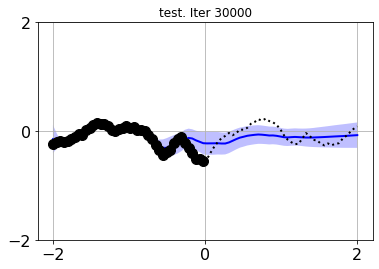

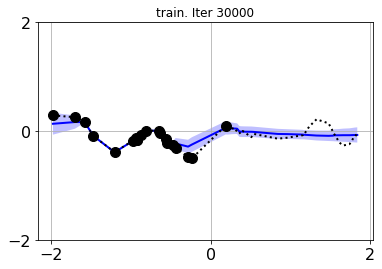


train: 31000 loss=-1.449 val_loss=-0.8147



train: 32000 loss=-0.05571 val_loss= 0.152



train: 33000 loss=-0.8461 val_loss=-0.3391



train: 34000 loss=-1.113 val_loss=-0.5331



train: 35000 loss=-0.9694 val_loss=-0.2654



train: 36000 loss= 0.1966 val_loss= 0.3088



train: 37000 loss=-1.799 val_loss=-1.177



train: 38000 loss=-0.06064 val_loss=-0.7014



train: 39000 loss=-1.48 val_loss=-0.8212



train: 40000 loss=-1.815 val_loss=-0.9481


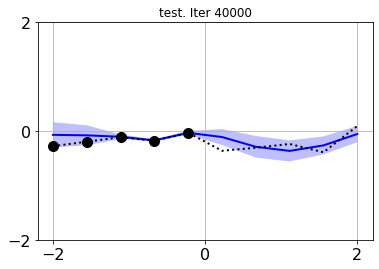

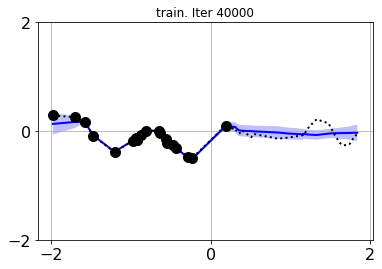


train: 41000 loss=-2.706 val_loss=-1.005



train: 42000 loss=-0.5594 val_loss=-0.2349



train: 43000 loss=-1.219 val_loss=-1.056



train: 44000 loss=-0.3377 val_loss=-1.179



train: 45000 loss=-0.4061 val_loss=-0.4364



train: 46000 loss=-0.08429 val_loss=-0.04039



train: 47000 loss=-1.933 val_loss=-0.8617



train: 48000 loss=-1.981 val_loss=-0.008101



train: 49000 loss=-1.696 val_loss=-0.8103



train: 50000 loss= 0.3421 val_loss=-0.7484


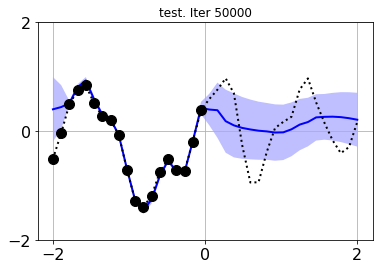

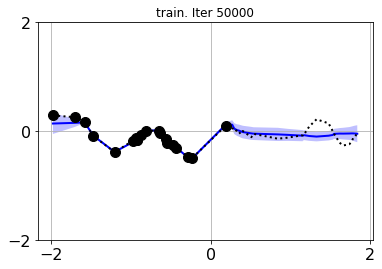


train: 51000 loss=-1.459 val_loss=-0.9305



train: 52000 loss=-1.204 val_loss=-1.361



train: 53000 loss=-1.697 val_loss=-1.113



train: 54000 loss=-0.8891 val_loss=-0.4821



train: 55000 loss=-2.534 val_loss=-1.295



train: 56000 loss=-1.076 val_loss= 0.9785



train: 57000 loss=-1.502 val_loss=-1.076



train: 58000 loss=-2.099 val_loss=-1.415



train: 59000 loss=-0.8996 val_loss=-0.643



train: 60000 loss=-0.7191 val_loss=-1.103


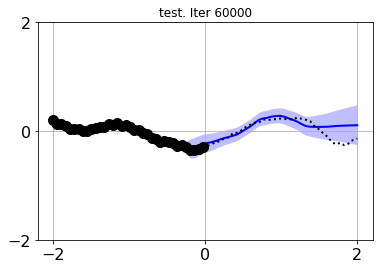

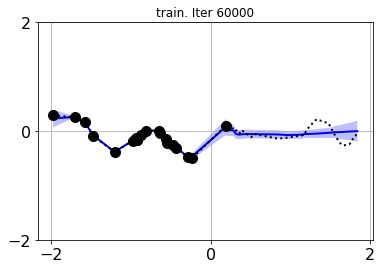


train: 61000 loss=-0.9859 val_loss=-1.039



train: 62000 loss=-1.015 val_loss=-0.7608



train: 63000 loss=-1.66 val_loss=-1.153



train: 64000 loss=-0.6775 val_loss= 0.09393



train: 65000 loss=-0.2821 val_loss=-1.129



train: 66000 loss=-1.5 val_loss=-0.8615



train: 67000 loss=-2.826 val_loss=-1.278



train: 68000 loss=-0.6377 val_loss=-1.593



train: 69000 loss=-2.587 val_loss=-1.243



train: 70000 loss=-2.64 val_loss=-1.237


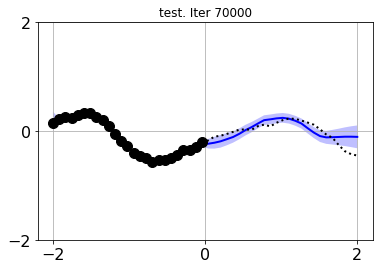

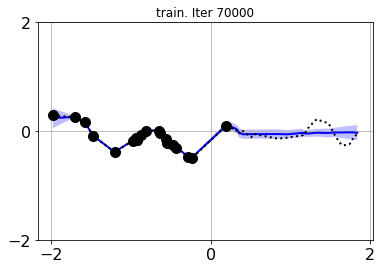


train: 71000 loss=-2.188 val_loss=-1.022



train: 72000 loss=-1.259 val_loss=-0.9904



train: 73000 loss=-3.012 val_loss=-1.546



train: 74000 loss=-2.061 val_loss=-1.265



train: 75000 loss=-2.419 val_loss=-0.8466



train: 76000 loss=-0.596 val_loss=-0.3414



train: 77000 loss=-1.105 val_loss=-0.6784



train: 78000 loss=-2.874 val_loss=-1.526



train: 79000 loss= 0.04059 val_loss= 0.2409



train: 80000 loss=-1.818 val_loss=-0.9628


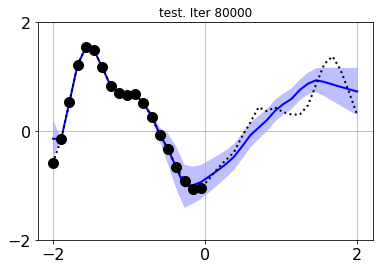

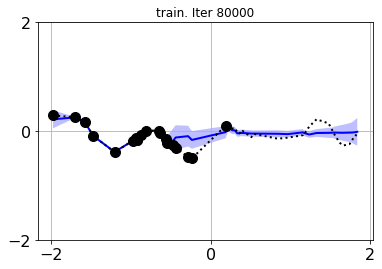


train: 81000 loss=-3.03 val_loss=-1.472



train: 82000 loss=-0.1856 val_loss=-0.01173



train: 83000 loss=-2.686 val_loss=-1.294



train: 84000 loss=-2.666 val_loss=-1.241



train: 85000 loss=-2.82 val_loss=-1.511



train: 86000 loss=-3.039 val_loss=-1.678



train: 87000 loss= 1.321 val_loss= 1.231



train: 88000 loss=-0.5502 val_loss=-0.5921



train: 89000 loss= 0.01962 val_loss= 0.2895



train: 90000 loss=-1.609 val_loss=-0.61


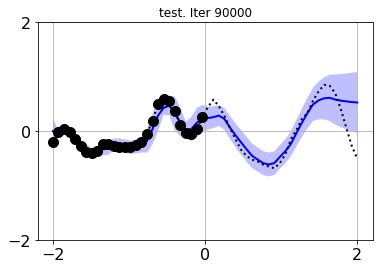

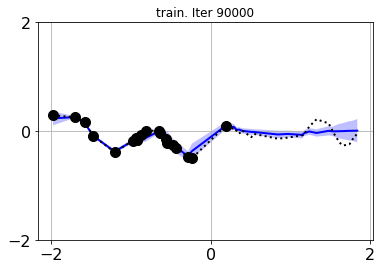


train: 91000 loss=-2.439 val_loss=-1.29



train: 92000 loss=-1.392 val_loss=-0.8917



train: 93000 loss=-1.926 val_loss=-1.707



train: 94000 loss=-1.669 val_loss=-1.171



train: 95000 loss=-1.912 val_loss=-1.561



train: 96000 loss=-0.2664 val_loss=-1.414



train: 97000 loss=-1.909 val_loss=-0.4816



train: 98000 loss= 0.2464 val_loss=-0.8018



train: 99000 loss=-1.368 val_loss=-1.498




val loss (n=300) tensor(-0.6238, device='cuda:0', grad_fn=<MeanBackward0>)


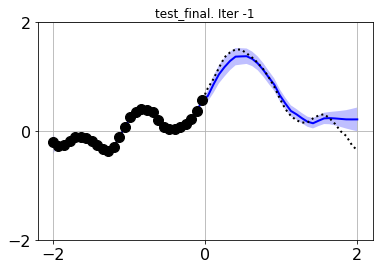

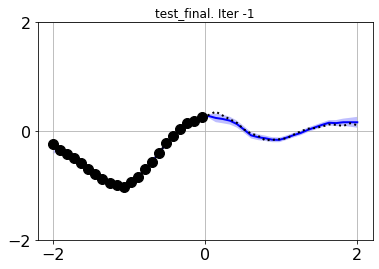

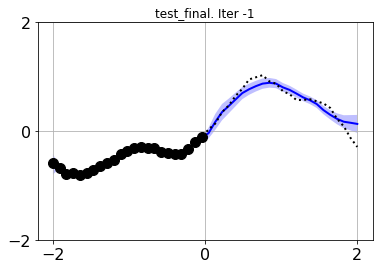

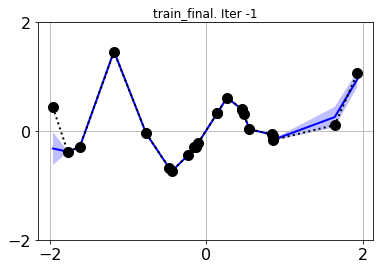

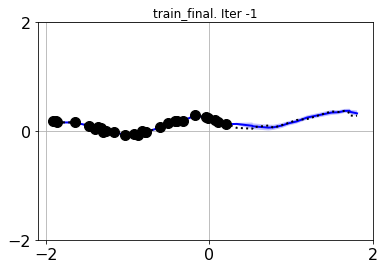

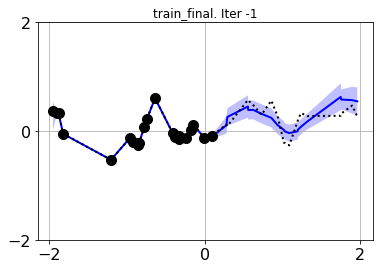

In [11]:


writer = SummaryWriter(comment='-anp-rnn_1d_reg')
print(writer.logdir)

hparams = dict(
    x_dim=1,
    y_dim=1,
    hidden_dim=128,
    latent_dim=128,
    latent_enc_self_attn_type="uniform",
    det_enc_self_attn_type="uniform",
    det_enc_cross_attn_type="multihead",
    use_rnn=True)
model = LatentModel(**hparams).cuda()

optim = torch.optim.Adam(model.parameters(), lr=1e-4)

for n_iter in tqdm(range(epochs)):
    model.train()

    data_train = dataset_train.generate_curves()

    (context_x, context_y), target_x = data_train.query
    target_y = data_train.target_y

    context_x = context_x.cuda()
    context_y = context_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    optim.zero_grad()
    y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x,
                                              target_y)
    loss.backward()
    optim.step()

    writer.add_scalar('train/loss', loss, n_iter)
    writer.add_scalar('train/mse_loss', mse_loss, n_iter)
    writer.add_scalar('train/y_std', y_std.mean(), n_iter)
    writer.add_scalar('train/kl', kl.mean(), n_iter)

    if n_iter % PRINT_AFTER == 0:
        y_pred, kl, val_loss, y_std = test(
            model, dataset_test, writer, plot=False, global_step=n_iter)
        val_loss = evaluate(model, dataset_test, 100)
        writer.add_scalar('val/loss_mean', val_loss, n_iter)
        print(
            f"train: {n_iter} loss={loss.item(): 4.4g} val_loss={val_loss.item(): 4.4g}"
        )

    if n_iter in PLOT_AFTER:
        test(model, dataset_test, writer, plot=True, global_step=n_iter, title='test')
        
        test(model, dataset_train, writer, plot=True, global_step=n_iter, seed=n_iter, title='train')
        
    # Final validation
val_loss = evaluate(model, dataset_test, 300)
print('val loss (n=300)', loss)
writer.add_hparams(hparams, dict(val_loss=loss))

for i in range(3):
    set_seed(i)
    test(model, dataset_test, writer, plot=True, global_step=-1, seed=i, title='test_final')
    
for i in range(3):
    test(model, dataset_train, writer, plot=True, global_step=-1, seed=i, title='train_final')

## Improved

These have no tbeen extensively tested:

runs/Feb16_00-03-08_mjcdesktop-anp-rnn_1d_impr



train: 0 loss= 1.569 val_loss= 1.586


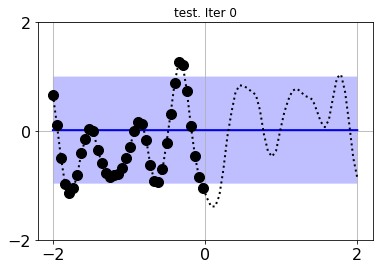

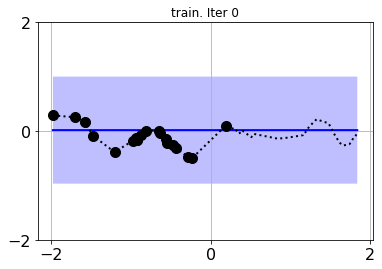

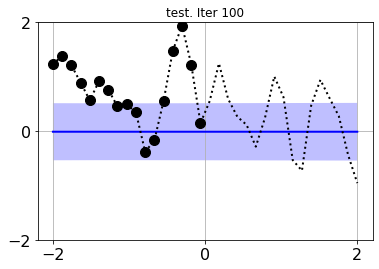

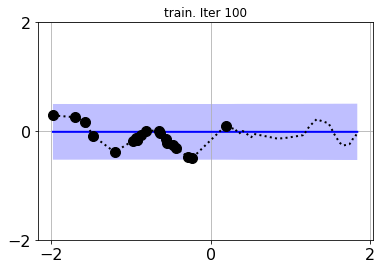

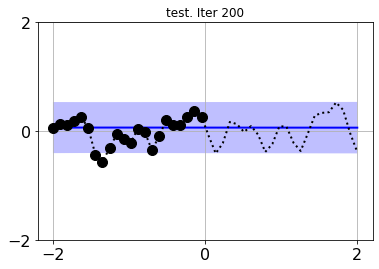

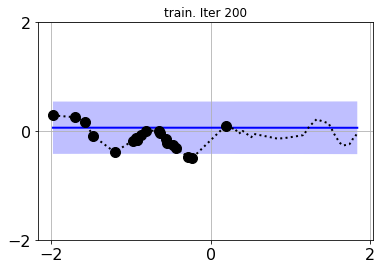

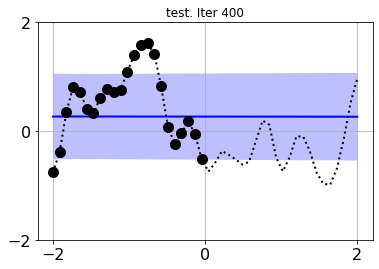

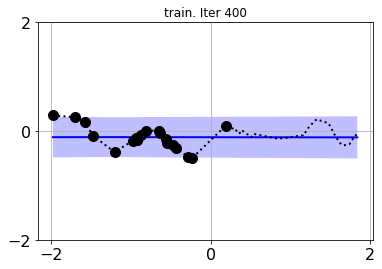


train: 1000 loss= 0.4848 val_loss= 0.4808


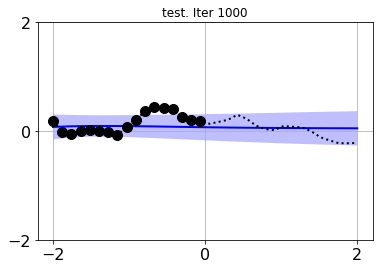

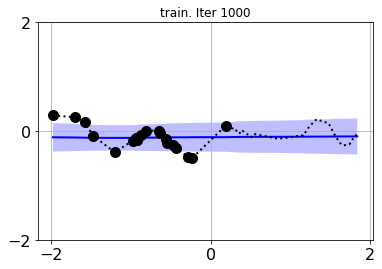


train: 2000 loss= 0.617 val_loss= 0.4292


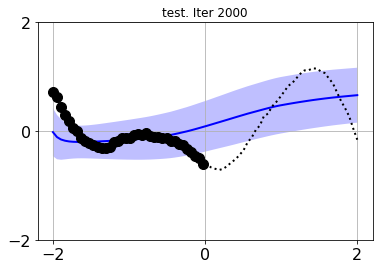

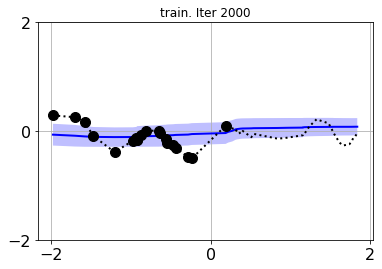


train: 3000 loss= 0.1891 val_loss= 0.3963



train: 4000 loss= 0.3194 val_loss= 0.3563


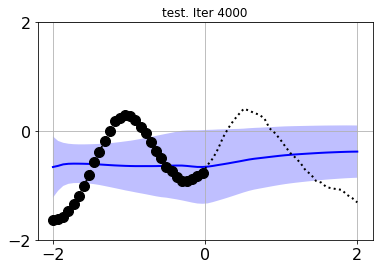

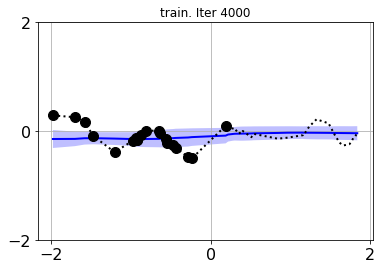


train: 5000 loss= 0.1481 val_loss= 0.35



train: 6000 loss= 0.3286 val_loss= 0.1296



train: 7000 loss= 0.3044 val_loss= 0.219



train: 8000 loss=-0.3851 val_loss=-0.1739


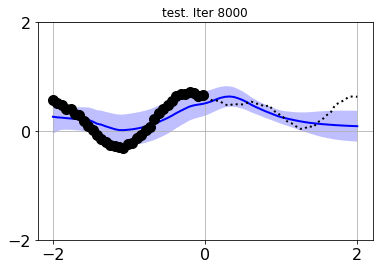

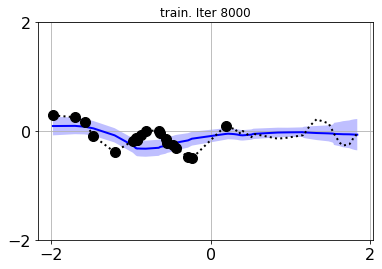


train: 9000 loss=-0.1591 val_loss=-0.1251



train: 10000 loss=-0.3405 val_loss=-0.1431


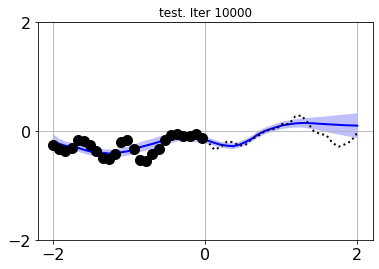

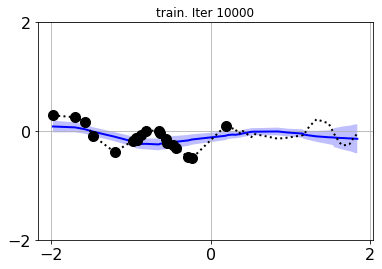


train: 11000 loss=-0.1793 val_loss=-0.04596



train: 12000 loss=-0.4151 val_loss=-0.3434



train: 13000 loss=-0.7291 val_loss=-0.3397



train: 14000 loss=-0.542 val_loss=-0.4848



train: 15000 loss=-0.6436 val_loss=-0.4202



train: 16000 loss=-0.6867 val_loss=-0.4677



train: 17000 loss=-0.5227 val_loss=-0.4778



train: 18000 loss=-0.4338 val_loss=-0.6027



train: 19000 loss=-0.4711 val_loss=-0.4555



train: 20000 loss=-0.6305 val_loss=-0.481


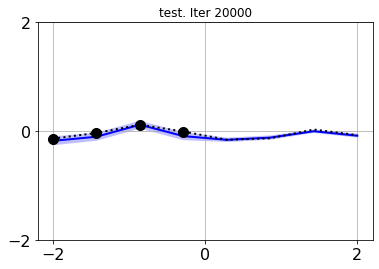

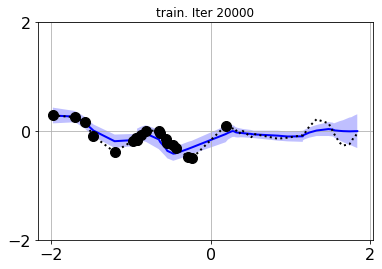


train: 21000 loss=-0.474 val_loss=-0.671



train: 22000 loss=-0.7145 val_loss=-0.5649



train: 23000 loss=-0.8894 val_loss=-0.6678



train: 24000 loss=-0.6787 val_loss=-0.6029



train: 25000 loss=-1.087 val_loss=-0.8553



train: 26000 loss=-1.175 val_loss=-0.7792



train: 27000 loss=-0.904 val_loss=-0.882



train: 28000 loss=-1.051 val_loss=-0.7785



train: 29000 loss=-0.6471 val_loss=-0.862



train: 30000 loss=-0.8829 val_loss=-0.7506


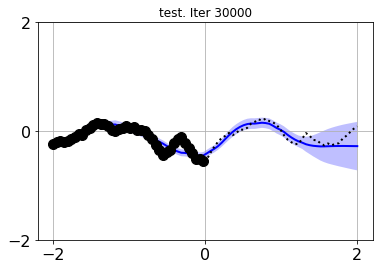

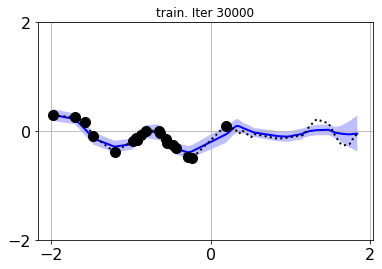


train: 31000 loss=-1.062 val_loss=-0.8208



train: 32000 loss=-1.282 val_loss=-0.9535



train: 33000 loss=-0.9241 val_loss=-0.8106



train: 34000 loss=-1.046 val_loss=-0.9872



train: 35000 loss=-0.9581 val_loss=-0.8569



train: 36000 loss=-1.235 val_loss=-0.973



train: 37000 loss=-0.796 val_loss=-1.094



train: 38000 loss=-1.087 val_loss=-0.9314



train: 39000 loss=-1.074 val_loss=-1.199



train: 40000 loss=-1.117 val_loss=-0.9872


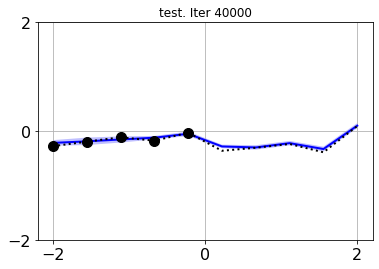

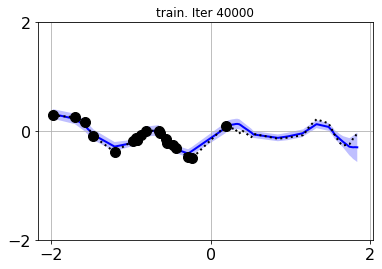


train: 41000 loss=-1.319 val_loss=-1.024



train: 42000 loss=-1.313 val_loss=-1.072



train: 43000 loss=-1.155 val_loss=-1.095



train: 44000 loss=-1.352 val_loss=-1.097



train: 45000 loss=-1.138 val_loss=-1.232



train: 46000 loss=-1.101 val_loss=-1.336



train: 47000 loss=-1.126 val_loss=-1.201



train: 48000 loss=-1.426 val_loss=-1.156



train: 49000 loss=-1.526 val_loss=-1.385



train: 50000 loss=-1.033 val_loss=-1.149


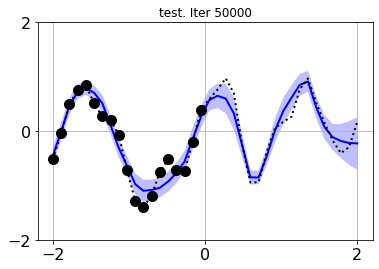

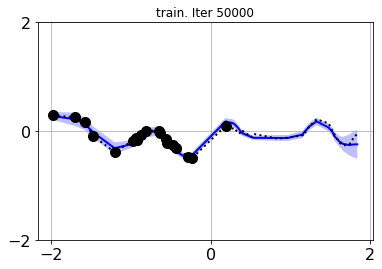


train: 51000 loss=-1.162 val_loss=-1.253



train: 52000 loss=-1.502 val_loss=-1.289



train: 53000 loss=-1.194 val_loss=-1.206



train: 54000 loss=-1.302 val_loss=-1.057



train: 55000 loss=-1.285 val_loss=-1.333



train: 56000 loss=-1.348 val_loss=-1.193



train: 57000 loss=-1.365 val_loss=-1.281



train: 58000 loss=-1.055 val_loss=-1.143



train: 59000 loss=-0.8762 val_loss=-1.163



train: 60000 loss=-1.211 val_loss=-1.288


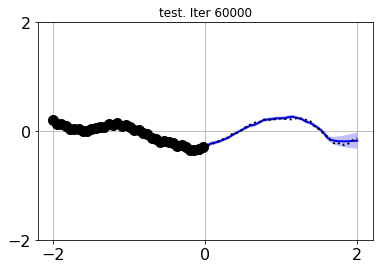

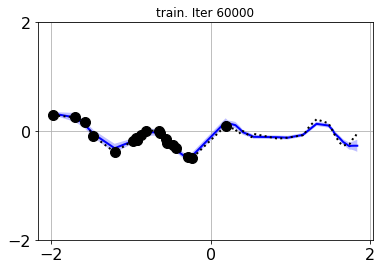


train: 61000 loss=-1.365 val_loss=-1.259



train: 62000 loss=-1.152 val_loss=-1.387



train: 63000 loss=-1.503 val_loss=-1.235



train: 64000 loss=-1.406 val_loss=-1.28



train: 65000 loss=-1.603 val_loss=-1.455



train: 66000 loss=-1.218 val_loss=-1.37



train: 67000 loss=-1.568 val_loss=-1.323



train: 68000 loss=-1.136 val_loss=-1.39



train: 69000 loss=-1.42 val_loss=-1.296



train: 70000 loss=-1.455 val_loss=-1.453


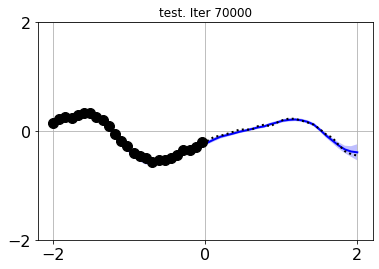

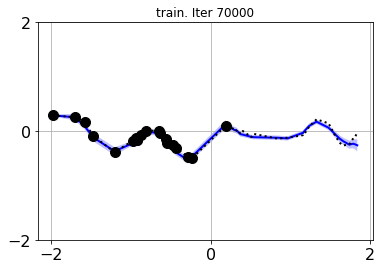


train: 71000 loss=-1.652 val_loss=-1.314



train: 72000 loss=-1.752 val_loss=-1.369



train: 73000 loss=-1.787 val_loss=-1.343



train: 74000 loss=-1.539 val_loss=-1.29



train: 75000 loss=-1.417 val_loss=-1.39



train: 76000 loss=-1.428 val_loss=-1.32



train: 77000 loss=-1.092 val_loss=-1.494



train: 78000 loss=-1.442 val_loss=-1.568



train: 79000 loss=-1.717 val_loss=-1.432



train: 80000 loss=-1.509 val_loss=-1.362


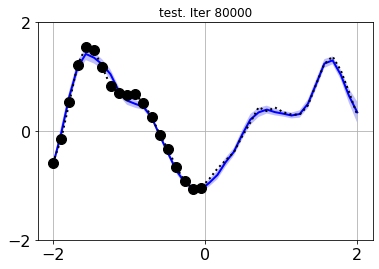

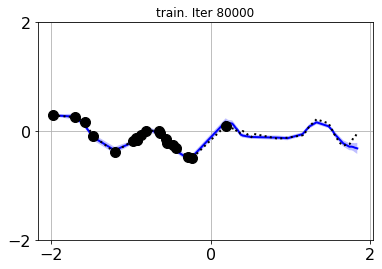


train: 81000 loss=-1.617 val_loss=-1.558



train: 82000 loss=-1.545 val_loss=-1.36



train: 83000 loss=-1.457 val_loss=-1.317



train: 84000 loss=-1.66 val_loss=-1.383



train: 85000 loss=-1.56 val_loss=-1.383



train: 86000 loss=-1.673 val_loss=-1.553



train: 87000 loss=-1.634 val_loss=-1.473



train: 88000 loss=-1.384 val_loss=-1.506



train: 89000 loss=-1.592 val_loss=-1.511



train: 90000 loss=-1.982 val_loss=-1.608


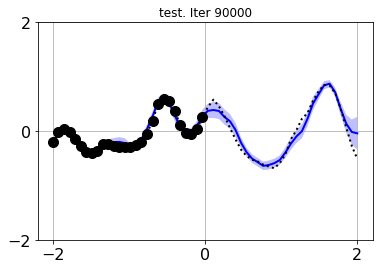

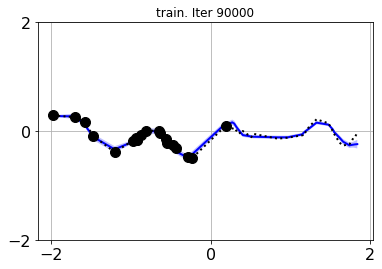


train: 91000 loss=-1.506 val_loss=-1.608



train: 92000 loss=-1.71 val_loss=-1.471



train: 93000 loss=-1.741 val_loss=-1.595



train: 94000 loss=-1.536 val_loss=-1.624



train: 95000 loss=-1.848 val_loss=-1.532



train: 96000 loss=-1.284 val_loss=-1.605



train: 97000 loss=-1.256 val_loss=-1.643



train: 98000 loss=-1.343 val_loss=-1.562



train: 99000 loss=-1.796 val_loss=-1.505




val loss (n=300) tensor(-1.3217, device='cuda:0', grad_fn=<MeanBackward0>)


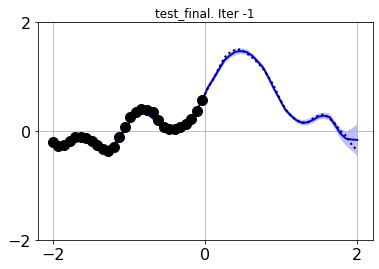

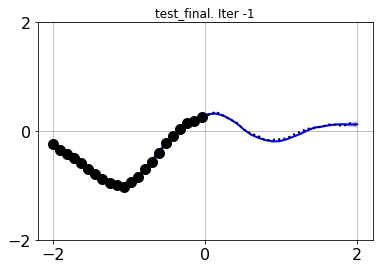

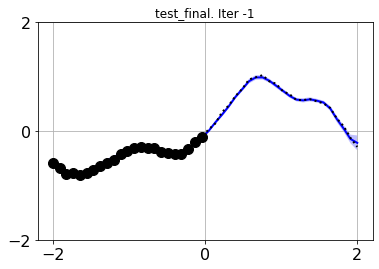

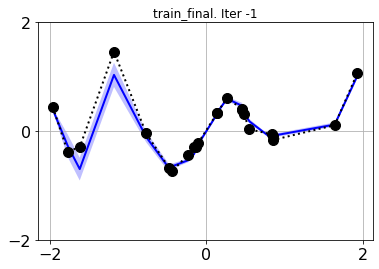

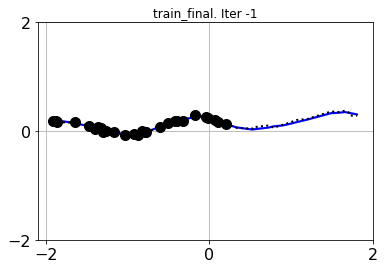

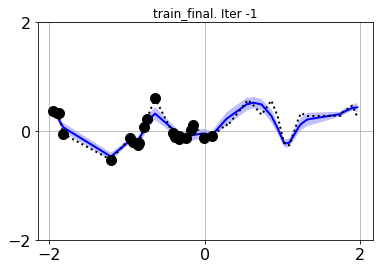

In [16]:
writer = SummaryWriter(comment='-anp-rnn_1d_impr')
print(writer.logdir)
                 
hparams = dict(
    x_dim=1,
    y_dim=1,
    hidden_dim=128,
    latent_dim=128,
    latent_enc_self_attn_type="ptmultihead",
    det_enc_self_attn_type="uniform",
    det_enc_cross_attn_type="uniform",
    use_rnn=True,
    min_std=1e-3,
    use_lvar=True,
    use_self_attn=True,
#     attention_dropout=0.3,
#     dropout=0.3,
#     batchnorm=True,
)
model = LatentModel(**hparams).cuda()

optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

for n_iter in tqdm(range(epochs)):
    model.train()

    data_train = dataset_train.generate_curves()

    (context_x, context_y), target_x = data_train.query
    target_y = data_train.target_y

    context_x = context_x.cuda()
    context_y = context_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    optim.zero_grad()
    y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x,
                                              target_y)
    loss.backward()
    optim.step()

    writer.add_scalar('train/loss', loss, n_iter)
    writer.add_scalar('train/mse_loss', mse_loss, n_iter)
    writer.add_scalar('train/y_std', y_std.mean(), n_iter)
    writer.add_scalar('train/kl', kl.mean(), n_iter)

    if n_iter % PRINT_AFTER == 0:
        y_pred, kl, val_loss, y_std = test(
            model, dataset_test, writer, plot=False, global_step=n_iter)
        val_loss = evaluate(model, dataset_test, 100)
        writer.add_scalar('val/loss_mean', val_loss, n_iter)
        print(
            f"train: {n_iter} loss={loss.item(): 4.4g} val_loss={val_loss.item(): 4.4g}"
        )

    if n_iter in PLOT_AFTER:
        test(model, dataset_test, writer, plot=True, global_step=n_iter, title='test')
        
        test(model, dataset_train, writer, plot=True, global_step=n_iter, seed=n_iter, title='train')
        
    # Final validation
val_loss = evaluate(model, dataset_test, 300)
print('val loss (n=300)', loss)
writer.add_hparams(hparams, dict(val_loss=loss))

for i in range(3):
    set_seed(i)
    test(model, dataset_test, writer, plot=True, global_step=-1, seed=i, title='test_final')
    
for i in range(3):
    test(model, dataset_train, writer, plot=True, global_step=-1, seed=i, title='train_final')

# ANP

runs/Feb16_02-22-45_mjcdesktop-anp_1d



train: 0 loss= 0.9118 val_loss= 0.9778


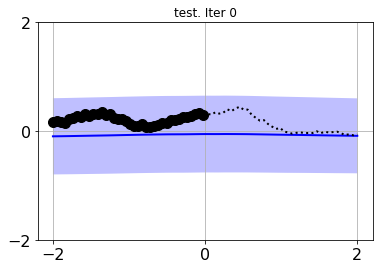

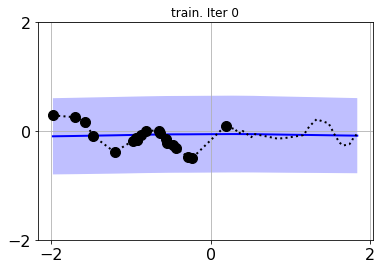

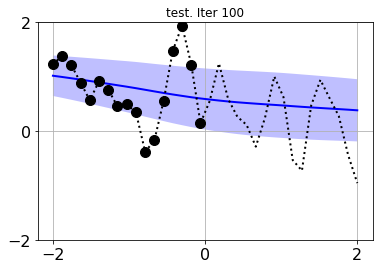

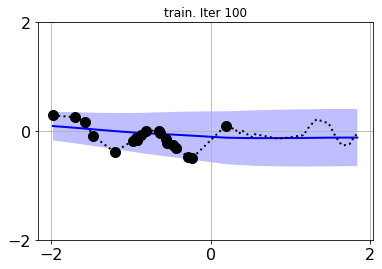

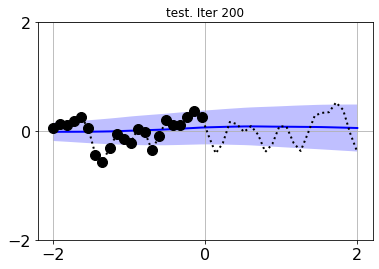

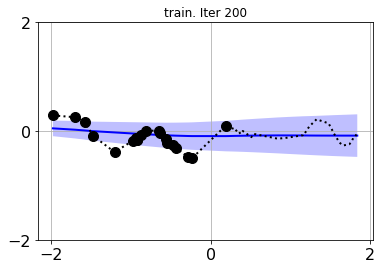

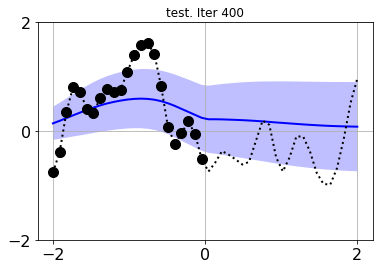

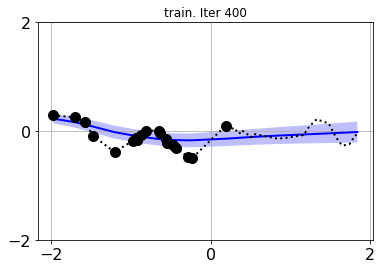


train: 1000 loss=-0.1999 val_loss= 0.1142


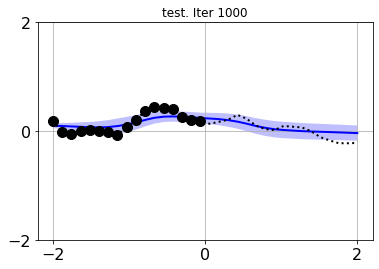

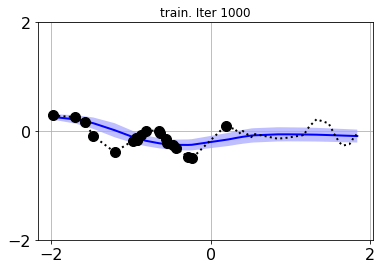


train: 2000 loss= 0.2029 val_loss= 0.07532


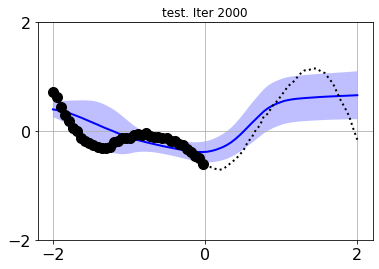

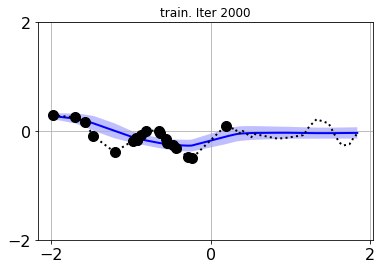


train: 3000 loss=-0.3327 val_loss= 0.04447



train: 4000 loss=-0.3029 val_loss=-0.04693


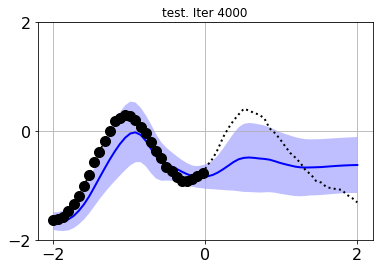

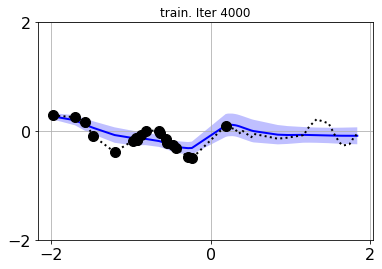


train: 5000 loss=-0.6767 val_loss=-0.1095



train: 6000 loss=-0.4898 val_loss=-0.3359



train: 7000 loss=-0.2736 val_loss=-0.225



train: 8000 loss=-0.9674 val_loss=-0.454


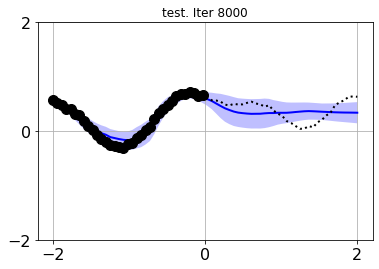

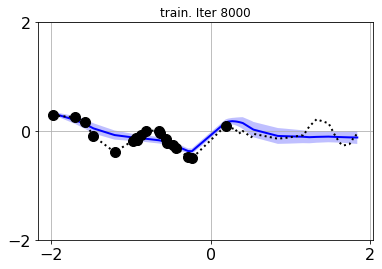


train: 9000 loss=-0.751 val_loss=-0.2591



train: 10000 loss=-0.7539 val_loss=-0.317


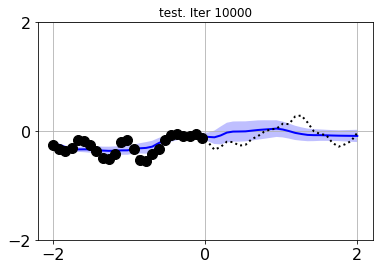

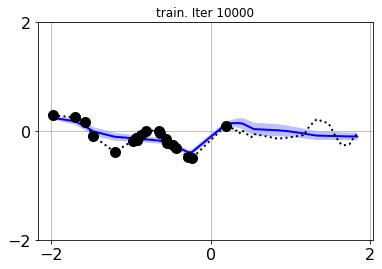


train: 11000 loss=-0.8861 val_loss=-0.4118



train: 12000 loss=-0.2832 val_loss=-0.4329



train: 13000 loss=-0.4234 val_loss=-0.432



train: 14000 loss=-0.8734 val_loss=-0.4333



train: 15000 loss=-0.7631 val_loss=-0.3911



train: 16000 loss=-1.03 val_loss=-0.3781



train: 17000 loss=-0.5164 val_loss=-0.3751



train: 18000 loss=-0.2309 val_loss=-0.5511



train: 19000 loss=-0.7256 val_loss=-0.3495



train: 20000 loss=-0.4653 val_loss=-0.3857


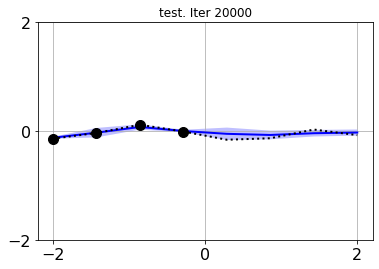

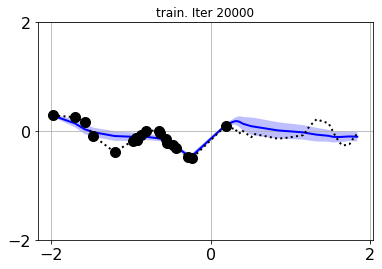


train: 21000 loss=-0.5868 val_loss=-0.5201



train: 22000 loss=-0.8419 val_loss=-0.3958



train: 23000 loss=-1.072 val_loss=-0.4602



train: 24000 loss=-0.5868 val_loss=-0.3205



train: 25000 loss=-1.072 val_loss=-0.6688



train: 26000 loss=-1.032 val_loss=-0.5645



train: 27000 loss=-0.8395 val_loss=-0.7123



train: 28000 loss=-0.6876 val_loss=-0.6253



train: 29000 loss=-0.165 val_loss=-0.6533



train: 30000 loss=-0.7898 val_loss=-0.5425


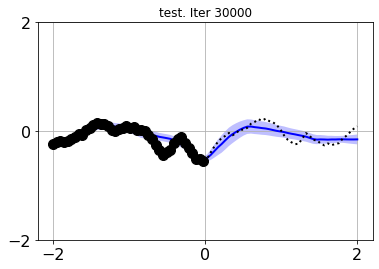

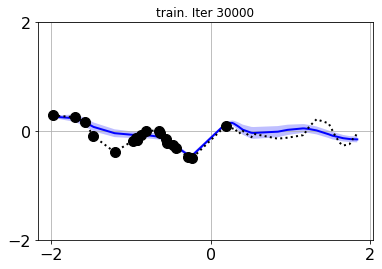


train: 31000 loss=-0.968 val_loss=-0.6066



train: 32000 loss=-1.25 val_loss=-0.6875



train: 33000 loss=-0.8995 val_loss=-0.683



train: 34000 loss=-0.9648 val_loss=-0.6648



train: 35000 loss=-0.5098 val_loss=-0.5854



train: 36000 loss=-0.8097 val_loss=-0.6329



train: 37000 loss=-0.7146 val_loss=-0.8085



train: 38000 loss=-0.3289 val_loss=-0.6244



train: 39000 loss=-0.9325 val_loss=-0.8636



train: 40000 loss=-1.052 val_loss=-0.6977


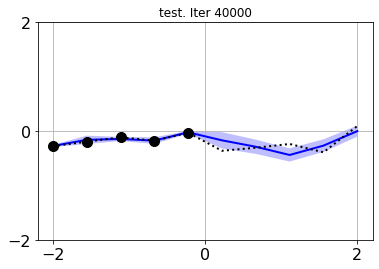

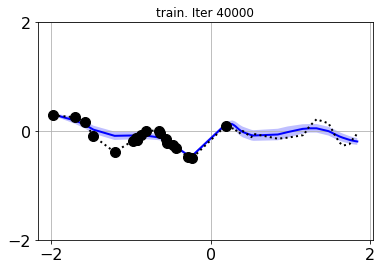


train: 41000 loss=-1.091 val_loss=-0.6033



train: 42000 loss=-0.7134 val_loss=-0.7348



train: 43000 loss=-0.6431 val_loss=-0.8281



train: 44000 loss=-0.5605 val_loss=-0.635



train: 45000 loss=-0.8642 val_loss=-0.8141



train: 46000 loss=-0.6673 val_loss=-0.9339



train: 47000 loss=-1.008 val_loss=-0.7851



train: 48000 loss=-1.051 val_loss=-0.6582



train: 49000 loss=-1.191 val_loss=-0.9108



train: 50000 loss=-0.04494 val_loss=-0.8216


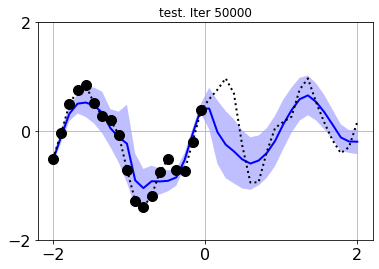

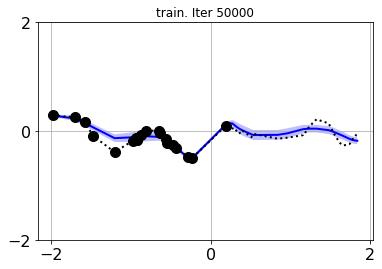


train: 51000 loss=-0.9069 val_loss=-0.7673



train: 52000 loss=-0.7994 val_loss=-0.7729



train: 53000 loss=-0.977 val_loss=-0.7795



train: 54000 loss=-0.8084 val_loss=-0.7531



train: 55000 loss=-0.9401 val_loss=-0.9735



train: 56000 loss=-1.206 val_loss=-0.701



train: 57000 loss=-0.986 val_loss=-0.7057



train: 58000 loss=-0.7796 val_loss=-0.8324



train: 59000 loss=-0.8086 val_loss=-0.7594



train: 60000 loss=-0.493 val_loss=-0.7668


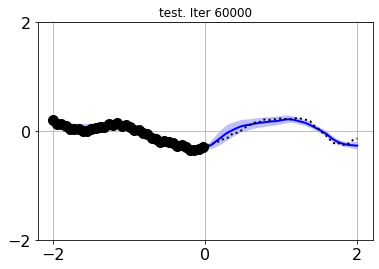

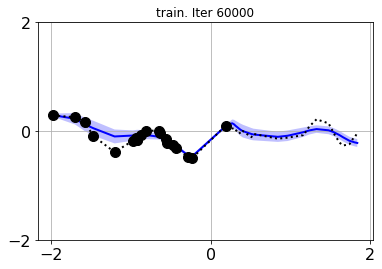


train: 61000 loss=-0.5046 val_loss=-0.8221



train: 62000 loss=-0.8124 val_loss=-0.9525



train: 63000 loss=-1.117 val_loss=-0.8664



train: 64000 loss=-0.8885 val_loss=-0.6662



train: 65000 loss=-0.5791 val_loss=-0.9529



train: 66000 loss=-0.8283 val_loss=-0.8742



train: 67000 loss=-1.162 val_loss=-0.8114



train: 68000 loss=-0.401 val_loss=-0.8386



train: 69000 loss=-1.053 val_loss=-0.8081



train: 70000 loss=-1.077 val_loss=-1.122


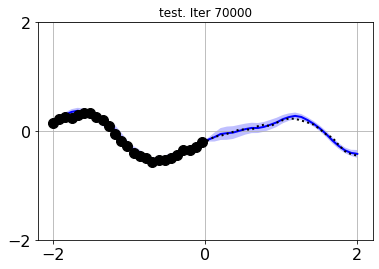

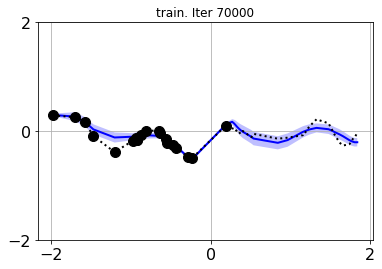


train: 71000 loss=-1.166 val_loss=-0.7812



train: 72000 loss=-0.9502 val_loss=-0.8054



train: 73000 loss=-1.433 val_loss=-0.9047



train: 74000 loss=-1.333 val_loss=-0.8535



train: 75000 loss=-0.9758 val_loss=-0.9153



train: 76000 loss=-1.003 val_loss=-0.9049



train: 77000 loss=-0.6574 val_loss=-0.9919



train: 78000 loss=-1.136 val_loss=-1.065



train: 79000 loss=-1.241 val_loss=-0.9251



train: 80000 loss=-1.186 val_loss=-0.7927


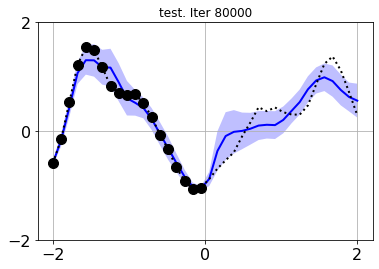

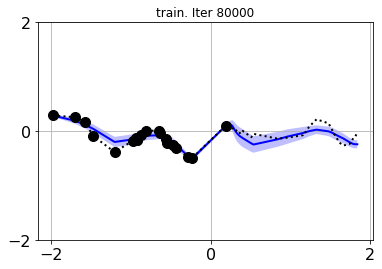


train: 81000 loss=-1.382 val_loss=-1.003



train: 82000 loss=-1.264 val_loss=-1.027



train: 83000 loss=-1.098 val_loss=-0.8024



train: 84000 loss=-1.388 val_loss=-0.8715



train: 85000 loss=-1.246 val_loss=-0.948



train: 86000 loss=-1.378 val_loss=-1.013



train: 87000 loss=-1.209 val_loss=-0.886



train: 88000 loss=-0.7734 val_loss=-0.9068



train: 89000 loss=-1.255 val_loss=-0.9452



train: 90000 loss=-1.593 val_loss=-1.059


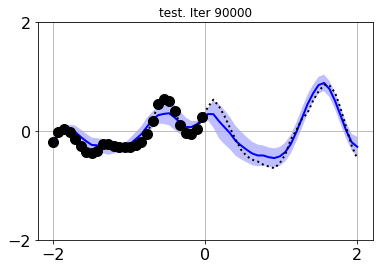

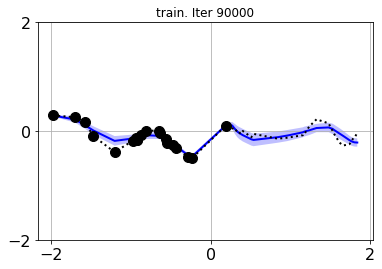


train: 91000 loss=-0.8692 val_loss=-0.879



train: 92000 loss=-1.07 val_loss=-0.9615



train: 93000 loss=-1.239 val_loss=-1.093



train: 94000 loss=-1.212 val_loss=-1.049



train: 95000 loss=-1.2 val_loss=-0.9322



train: 96000 loss=-0.3922 val_loss=-1.086



train: 97000 loss=-1.015 val_loss=-1.165



train: 98000 loss=-0.2694 val_loss=-0.9911



train: 99000 loss=-1.004 val_loss=-0.9867




val loss (n=300) tensor(-0.3182, device='cuda:0', grad_fn=<MeanBackward0>)


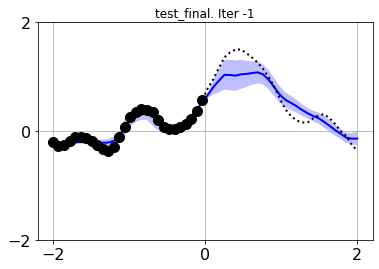

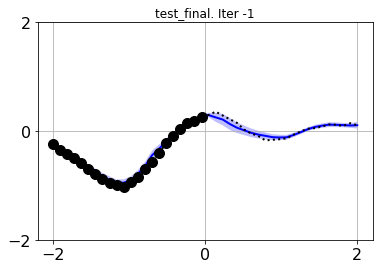

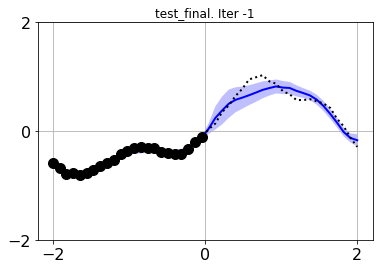

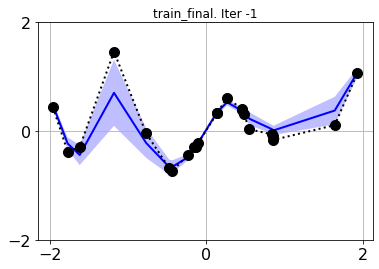

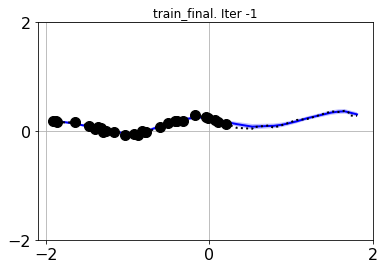

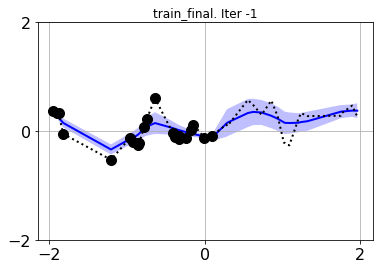

In [17]:
writer = SummaryWriter(comment='-anp_1d')
print(writer.logdir)
                 
hparams = dict(
    x_dim=1,
    y_dim=1,
    hidden_dim=128,
    latent_dim=128,
    latent_enc_self_attn_type="multihead",
    det_enc_self_attn_type="multihead",
    det_enc_cross_attn_type="multihead",
    use_rnn=False)
model = LatentModel(**hparams).cuda()

optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

for n_iter in tqdm(range(epochs)):
    model.train()

    data_train = dataset_train.generate_curves()

    (context_x, context_y), target_x = data_train.query
    target_y = data_train.target_y

    context_x = context_x.cuda()
    context_y = context_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    optim.zero_grad()
    y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x,
                                              target_y)
    loss.backward()
    optim.step()

    writer.add_scalar('train/loss', loss, n_iter)
    writer.add_scalar('train/mse_loss', mse_loss, n_iter)
    writer.add_scalar('train/y_std', y_std.mean(), n_iter)
    writer.add_scalar('train/kl', kl.mean(), n_iter)

    if n_iter % PRINT_AFTER == 0:
        y_pred, kl, val_loss, y_std = test(
            model, dataset_test, writer, plot=False, global_step=n_iter)
        val_loss = evaluate(model, dataset_test, 100)
        writer.add_scalar('val/loss_mean', val_loss, n_iter)
        print(
            f"train: {n_iter} loss={loss.item(): 4.4g} val_loss={val_loss.item(): 4.4g}"
        )

    if n_iter in PLOT_AFTER:
        test(model, dataset_test, writer, plot=True, global_step=n_iter, title='test')
        
        test(model, dataset_train, writer, plot=True, global_step=n_iter, seed=n_iter, title='train')
        
    # Final validation
val_loss = evaluate(model, dataset_test, 300)
print('val loss (n=300)', loss)
writer.add_hparams(hparams, dict(val_loss=loss))

for i in range(3):
    set_seed(i)
    test(model, dataset_test, writer, plot=True, global_step=-1, seed=i, title='test_final')
    
for i in range(3):
    test(model, dataset_train, writer, plot=True, global_step=-1, seed=i, title='train_final')

runs/Feb16_04-56-39_mjcdesktop-anp_1d



train: 0 loss= 1.578 val_loss= 1.594


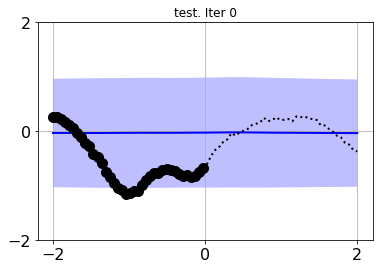

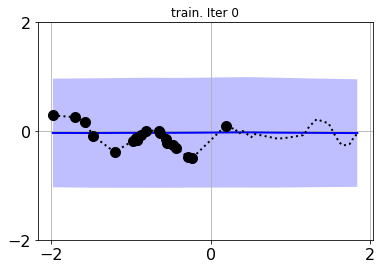

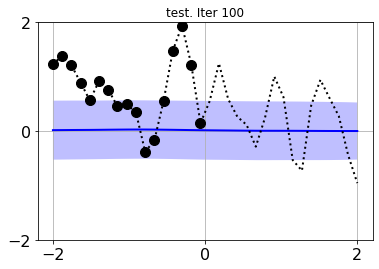

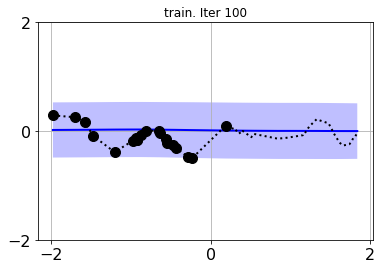

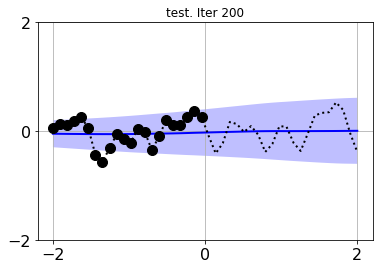

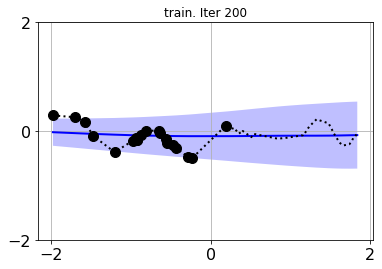

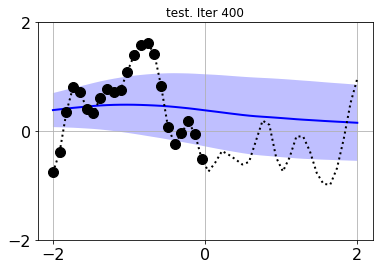

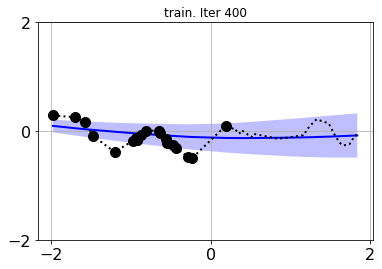


train: 1000 loss=-0.02011 val_loss= 0.2265


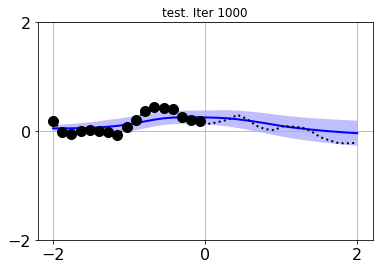

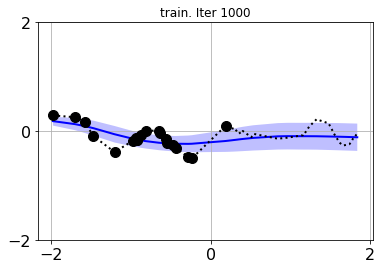


train: 2000 loss= 0.3313 val_loss= 0.1654


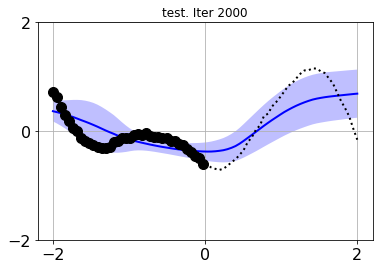

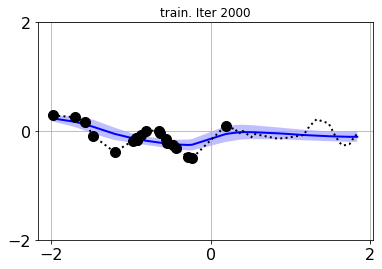


train: 3000 loss=-0.2077 val_loss= 0.1123



train: 4000 loss=-0.1993 val_loss= 0.06822


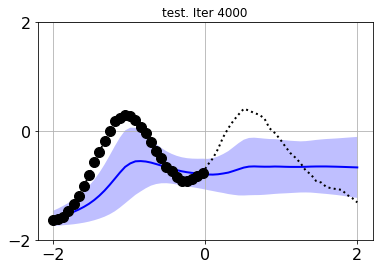

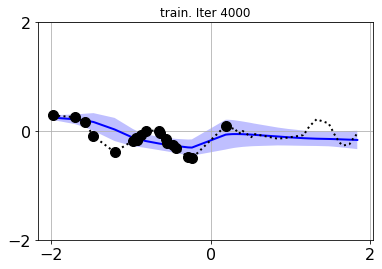


train: 5000 loss=-0.3065 val_loss= 0.09958



train: 6000 loss=-0.2163 val_loss=-0.1013



train: 7000 loss=-0.006919 val_loss= 0.03911



train: 8000 loss=-0.6638 val_loss=-0.183


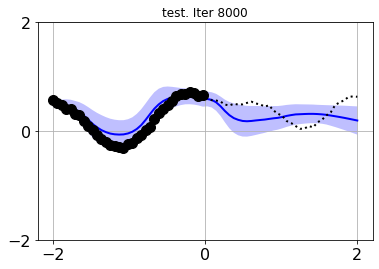

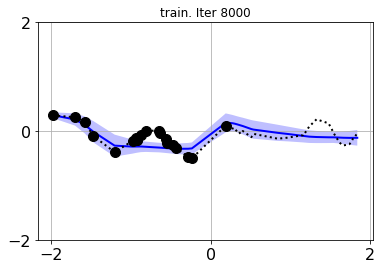


train: 9000 loss=-0.3583 val_loss=-0.03539



train: 10000 loss=-0.353 val_loss=-0.06751


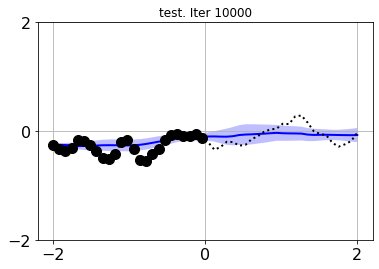

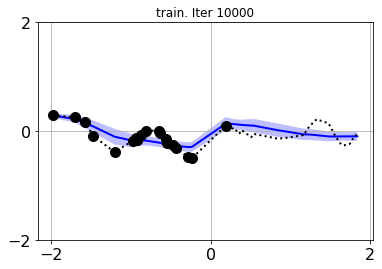


train: 11000 loss=-0.5911 val_loss=-0.1901



train: 12000 loss=-0.07633 val_loss=-0.2601



train: 13000 loss=-0.2962 val_loss=-0.2096



train: 14000 loss=-0.6172 val_loss=-0.2644



train: 15000 loss=-0.5576 val_loss=-0.2546



train: 16000 loss=-0.9652 val_loss=-0.2489



train: 17000 loss=-0.4671 val_loss=-0.3229



train: 18000 loss=-0.1265 val_loss=-0.4242



train: 19000 loss=-0.5053 val_loss=-0.287



train: 20000 loss=-0.4279 val_loss=-0.3667


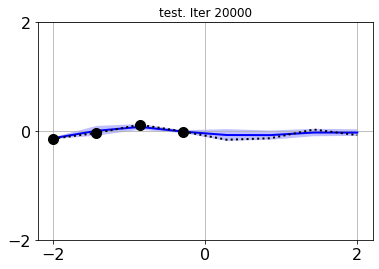

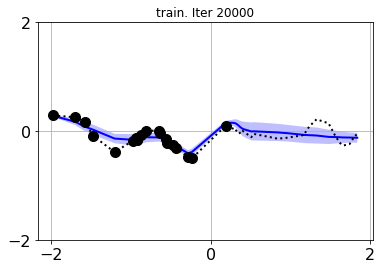


train: 21000 loss=-0.4248 val_loss=-0.4346



train: 22000 loss=-0.6823 val_loss=-0.3301



train: 23000 loss=-0.9004 val_loss=-0.4185



train: 24000 loss=-0.5291 val_loss=-0.2571



train: 25000 loss=-0.9307 val_loss=-0.6093



train: 26000 loss=-1.019 val_loss=-0.5442



train: 27000 loss=-0.7284 val_loss=-0.6883



train: 28000 loss=-0.5333 val_loss=-0.5242



train: 29000 loss=-0.2044 val_loss=-0.6285



train: 30000 loss=-0.7489 val_loss=-0.5512


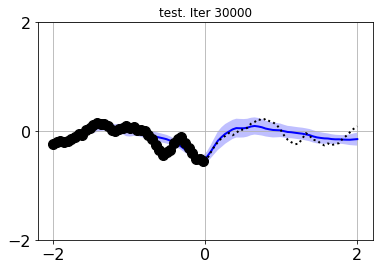

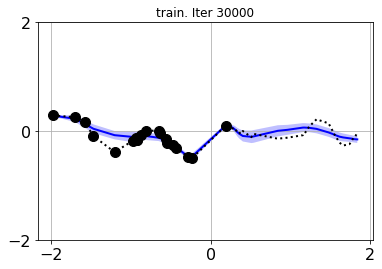


train: 31000 loss=-0.8568 val_loss=-0.5416



train: 32000 loss=-1.081 val_loss=-0.672



train: 33000 loss=-0.8046 val_loss=-0.6354



train: 34000 loss=-0.9273 val_loss=-0.673



train: 35000 loss=-0.5834 val_loss=-0.5694



train: 36000 loss=-0.8014 val_loss=-0.6329



train: 37000 loss=-0.7178 val_loss=-0.7755



train: 38000 loss=-0.3445 val_loss=-0.6073



train: 39000 loss=-0.9556 val_loss=-0.805



train: 40000 loss=-0.9941 val_loss=-0.6704


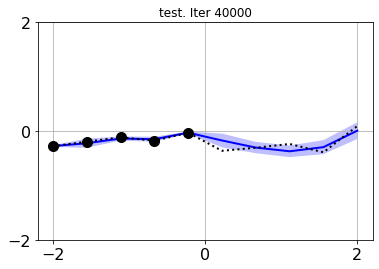

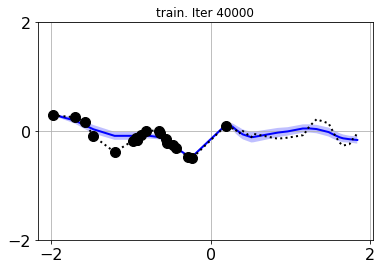


train: 41000 loss=-1.047 val_loss=-0.611



train: 42000 loss=-0.6729 val_loss=-0.6841



train: 43000 loss=-0.6311 val_loss=-0.7858



train: 44000 loss=-0.4916 val_loss=-0.4763



train: 45000 loss=-0.8974 val_loss=-0.7627



train: 46000 loss=-0.6319 val_loss=-0.8936



train: 47000 loss=-0.9055 val_loss=-0.7595



train: 48000 loss=-1.095 val_loss=-0.6749



train: 49000 loss=-1.195 val_loss=-0.7932



train: 50000 loss=-0.06208 val_loss=-0.7879


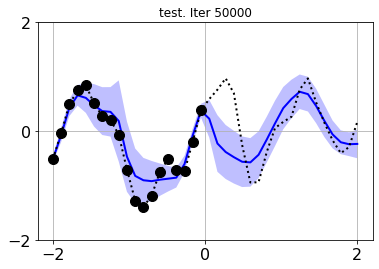

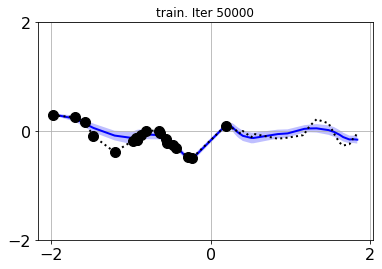


train: 51000 loss=-0.8243 val_loss=-0.7606



train: 52000 loss=-0.7935 val_loss=-0.7798



train: 53000 loss=-0.9096 val_loss=-0.7303



train: 54000 loss=-0.8063 val_loss=-0.7399



train: 55000 loss=-0.8514 val_loss=-0.9208



train: 56000 loss=-1.158 val_loss=-0.7181



train: 57000 loss=-0.8632 val_loss=-0.6477



train: 58000 loss=-0.7471 val_loss=-0.8283



train: 59000 loss=-0.6533 val_loss=-0.7788



train: 60000 loss=-0.4517 val_loss=-0.7565


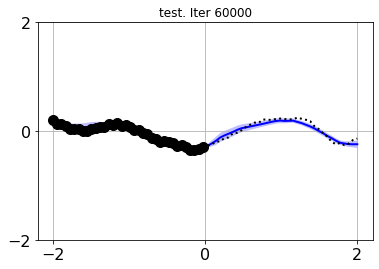

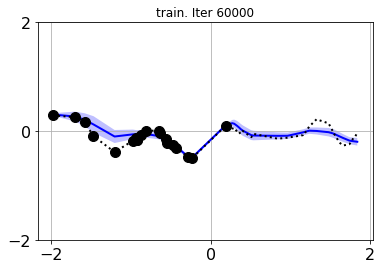


train: 61000 loss=-0.5638 val_loss=-0.805



train: 62000 loss=-0.759 val_loss=-0.923



train: 63000 loss=-1.113 val_loss=-0.8119



train: 64000 loss=-0.8336 val_loss=-0.7304



train: 65000 loss=-0.5435 val_loss=-0.8465



train: 66000 loss=-0.8401 val_loss=-0.8899



train: 67000 loss=-1.111 val_loss=-0.8268



train: 68000 loss=-0.4738 val_loss=-0.8169



train: 69000 loss=-1.042 val_loss=-0.7349



train: 70000 loss=-1.112 val_loss=-1.122


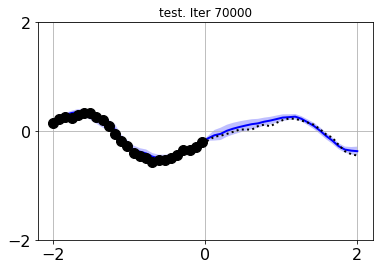

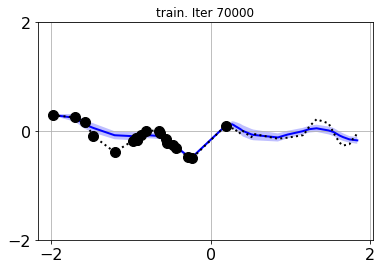


train: 71000 loss=-1.156 val_loss=-0.7786



train: 72000 loss=-0.9984 val_loss=-0.8394



train: 73000 loss=-1.35 val_loss=-0.9151



train: 74000 loss=-1.212 val_loss=-0.8436



train: 75000 loss=-0.8215 val_loss=-0.8068



train: 76000 loss=-1.016 val_loss=-0.8846



train: 77000 loss=-0.6099 val_loss=-0.914



train: 78000 loss=-1.156 val_loss=-1.076



train: 79000 loss=-1.26 val_loss=-0.9029



train: 80000 loss=-1.027 val_loss=-0.7827


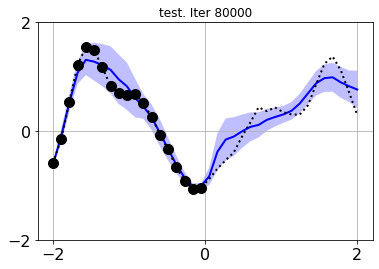

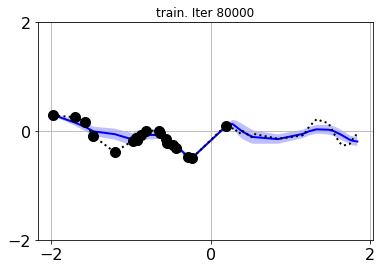


train: 81000 loss=-1.343 val_loss=-1.001



train: 82000 loss=-1.277 val_loss=-1.018



train: 83000 loss=-0.9921 val_loss=-0.799



train: 84000 loss=-1.217 val_loss=-0.837



train: 85000 loss=-1.175 val_loss=-0.9341



train: 86000 loss=-1.285 val_loss=-1.064



train: 87000 loss=-1.144 val_loss=-0.8846



train: 88000 loss=-0.714 val_loss=-0.9119



train: 89000 loss=-1.254 val_loss=-0.9565



train: 90000 loss=-1.531 val_loss=-1.042


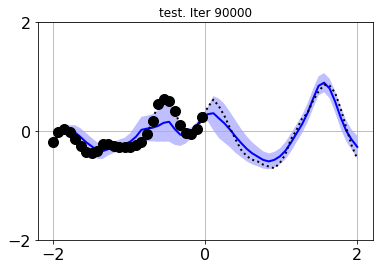

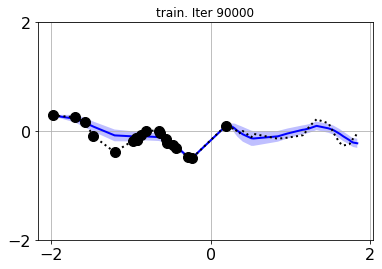


train: 91000 loss=-0.6479 val_loss=-0.7162



train: 92000 loss=-1.109 val_loss=-0.9726



train: 93000 loss=-1.279 val_loss=-1.059



train: 94000 loss=-1.151 val_loss=-1.031



train: 95000 loss=-1.193 val_loss=-0.9117



train: 96000 loss=-0.4153 val_loss=-1.078



train: 97000 loss=-0.8927 val_loss=-1.14



train: 98000 loss=-0.2916 val_loss=-0.9741



train: 99000 loss=-1.05 val_loss=-0.9865




val loss (n=300) tensor(-0.4228, device='cuda:0', grad_fn=<MeanBackward0>)


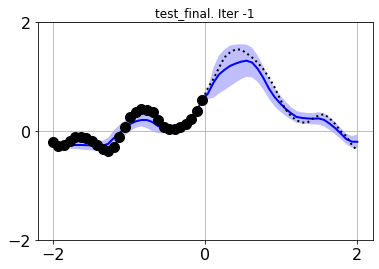

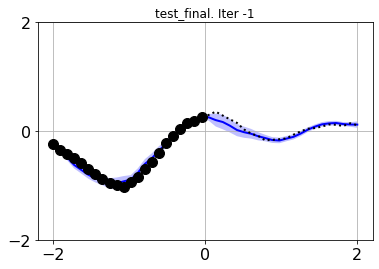

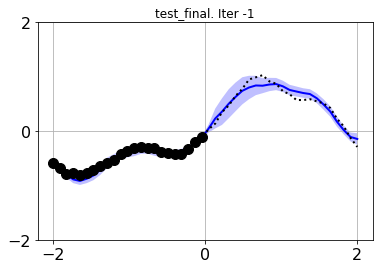

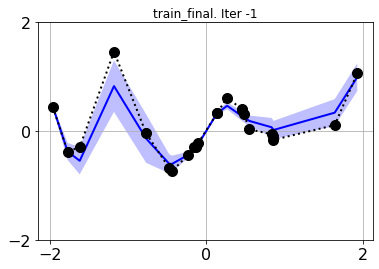

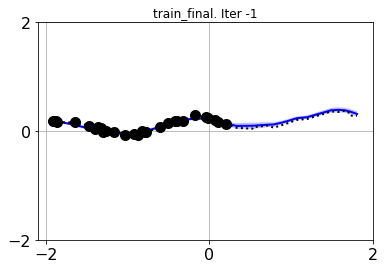

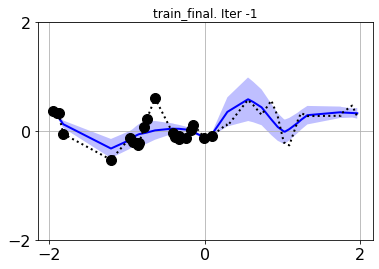

In [18]:
writer = SummaryWriter(comment='-anp_1d_impr')
print(writer.logdir)
                 
hparams = dict(
    x_dim=1,
    y_dim=1,
    hidden_dim=128,
    latent_dim=128,
    latent_enc_self_attn_type="ptmultihead",
    det_enc_self_attn_type="ptmultihead",
    det_enc_cross_attn_type="ptmultihead",
    use_lvar=True,
    use_rnn=False)
model = LatentModel(**hparams).cuda()

optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

for n_iter in tqdm(range(epochs)):
    model.train()

    data_train = dataset_train.generate_curves()

    (context_x, context_y), target_x = data_train.query
    target_y = data_train.target_y

    context_x = context_x.cuda()
    context_y = context_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    optim.zero_grad()
    y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x,
                                              target_y)
    loss.backward()
    optim.step()

    writer.add_scalar('train/loss', loss, n_iter)
    writer.add_scalar('train/mse_loss', mse_loss, n_iter)
    writer.add_scalar('train/y_std', y_std.mean(), n_iter)
    writer.add_scalar('train/kl', kl.mean(), n_iter)

    if n_iter % PRINT_AFTER == 0:
        y_pred, kl, val_loss, y_std = test(
            model, dataset_test, writer, plot=False, global_step=n_iter)
        val_loss = evaluate(model, dataset_test, 100)
        writer.add_scalar('val/loss_mean', val_loss, n_iter)
        print(
            f"train: {n_iter} loss={loss.item(): 4.4g} val_loss={val_loss.item(): 4.4g}"
        )

    if n_iter in PLOT_AFTER:
        test(model, dataset_test, writer, plot=True, global_step=n_iter, title='test')
        
        test(model, dataset_train, writer, plot=True, global_step=n_iter, seed=n_iter, title='train')
        
    # Final validation
val_loss = evaluate(model, dataset_test, 300)
print('val loss (n=300)', loss)
writer.add_hparams(hparams, dict(val_loss=loss))

for i in range(3):
    set_seed(i)
    test(model, dataset_test, writer, plot=True, global_step=-1, seed=i, title='test_final')
    
for i in range(3):
    test(model, dataset_train, writer, plot=True, global_step=-1, seed=i, title='train_final')

# NP

runs/Feb16_07-08-51_mjcdesktop-np_1d



train: 0 loss= 1.082 val_loss= 0.9136


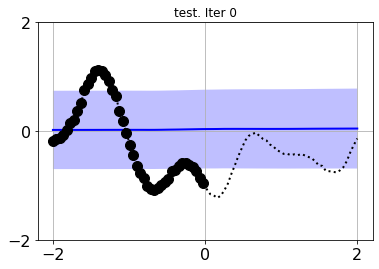

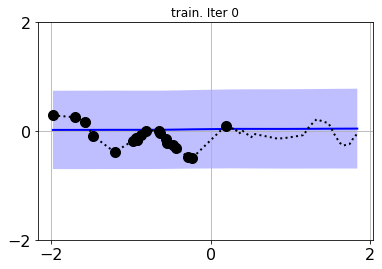


train: 100 loss= 0.9248 val_loss= 0.8073


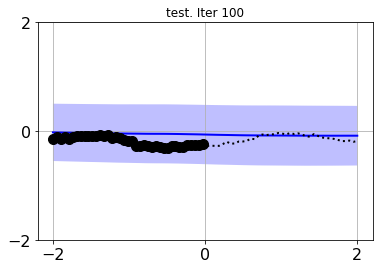

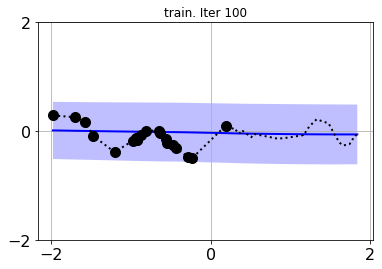


train: 200 loss= 0.2588 val_loss= 0.5565


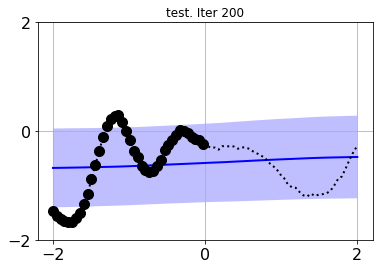

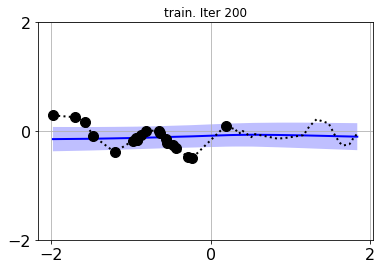


train: 400 loss= 0.2666 val_loss= 0.4395


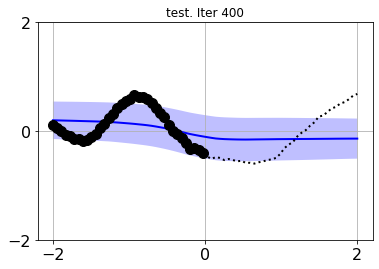

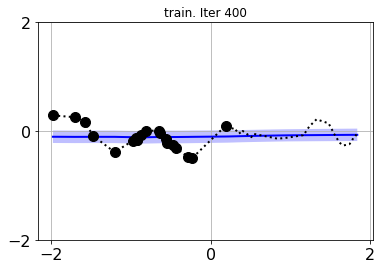


train: 1000 loss= 0.1996 val_loss= 0.2852


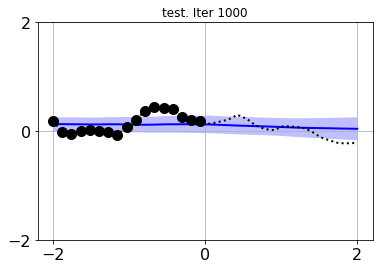

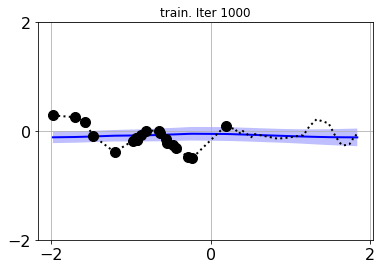


train: 2000 loss= 0.4812 val_loss= 0.2063


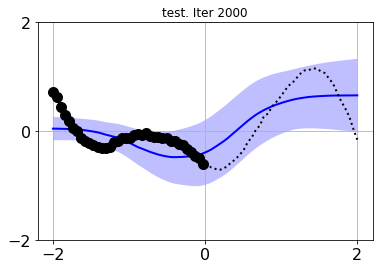

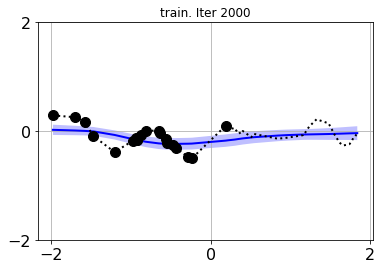


train: 4000 loss=-0.1101 val_loss=-0.02517


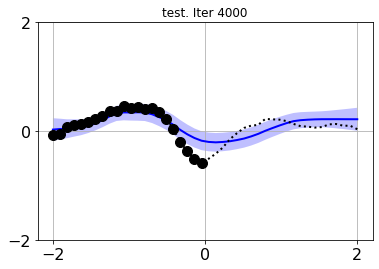

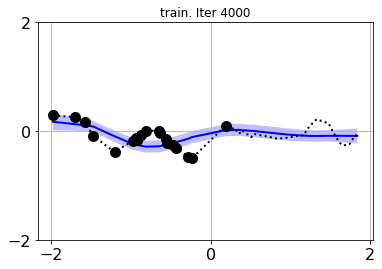


train: 8000 loss=-0.08965 val_loss=-0.1031


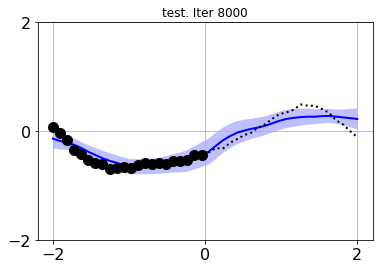

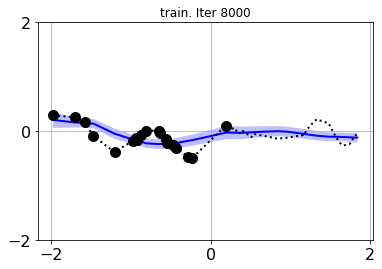


train: 10000 loss= 0.2389 val_loss=-0.1605


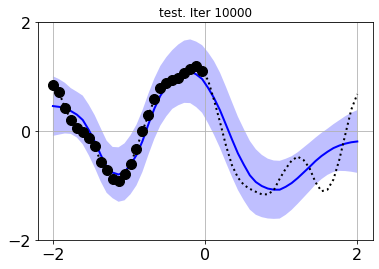

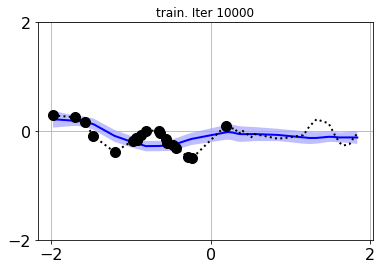

In [ ]:
writer = SummaryWriter(comment='-np_1d')
print(writer.logdir)
                 
hparams = dict(
    x_dim=1,
    y_dim=1,
    hidden_dim=128,
    latent_dim=128,
    latent_enc_self_attn_type="uniform",
    det_enc_self_attn_type="uniform",
    det_enc_cross_attn_type="uniform",
    use_rnn=False)
model = LatentModel(**hparams).cuda()

optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

for n_iter in tqdm(range(epochs)):
    model.train()

    data_train = dataset_train.generate_curves()

    (context_x, context_y), target_x = data_train.query
    target_y = data_train.target_y

    context_x = context_x.cuda()
    context_y = context_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    optim.zero_grad()
    y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x,
                                              target_y)
    loss.backward()
    optim.step()

    writer.add_scalar('train/loss', loss, n_iter)
    writer.add_scalar('train/mse_loss', mse_loss, n_iter)
    writer.add_scalar('train/y_std', y_std.mean(), n_iter)
    writer.add_scalar('train/kl', kl.mean(), n_iter)

    if n_iter in PLOT_AFTER:
        y_pred, kl, val_loss, y_std = test(
            model, dataset_test, writer, plot=False, global_step=n_iter)
        val_loss = evaluate(model, dataset_test, 100)
        writer.add_scalar('val/loss_mean', val_loss, n_iter)
        print(
            f"train: {n_iter} loss={loss.item(): 4.4g} val_loss={val_loss.item(): 4.4g}"
        )

    if n_iter in PLOT_AFTER:
        test(model, dataset_test, writer, plot=True, global_step=n_iter, title='test')
        test(model, dataset_train, writer, plot=True, global_step=n_iter, seed=n_iter, title='train')